<h2><b> Importing Dataset and Libraries

In [1]:
!git clone https://github.com/microsoft/MS-SNSD.git

Cloning into 'MS-SNSD'...
remote: Enumerating objects: 29924, done.
remote: Total 29924 (delta 0), reused 0 (delta 0), pack-reused 29924 (from 1)
Receiving objects: 100% (29924/29924), 3.93 GiB | 34.25 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Updating files: 100% (24399/24399), done.


In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

<h2><b> Converting to Spectogram

In [19]:
base_dir='MS-SNSD/'
noisy_folder = os.path.join(base_dir, 'NoisySpeech_training')
clean_folder = os.path.join(base_dir, 'CleanSpeech_training')

Inspecting file: noisy396_SNRdb_10.0_clnsp396.wav


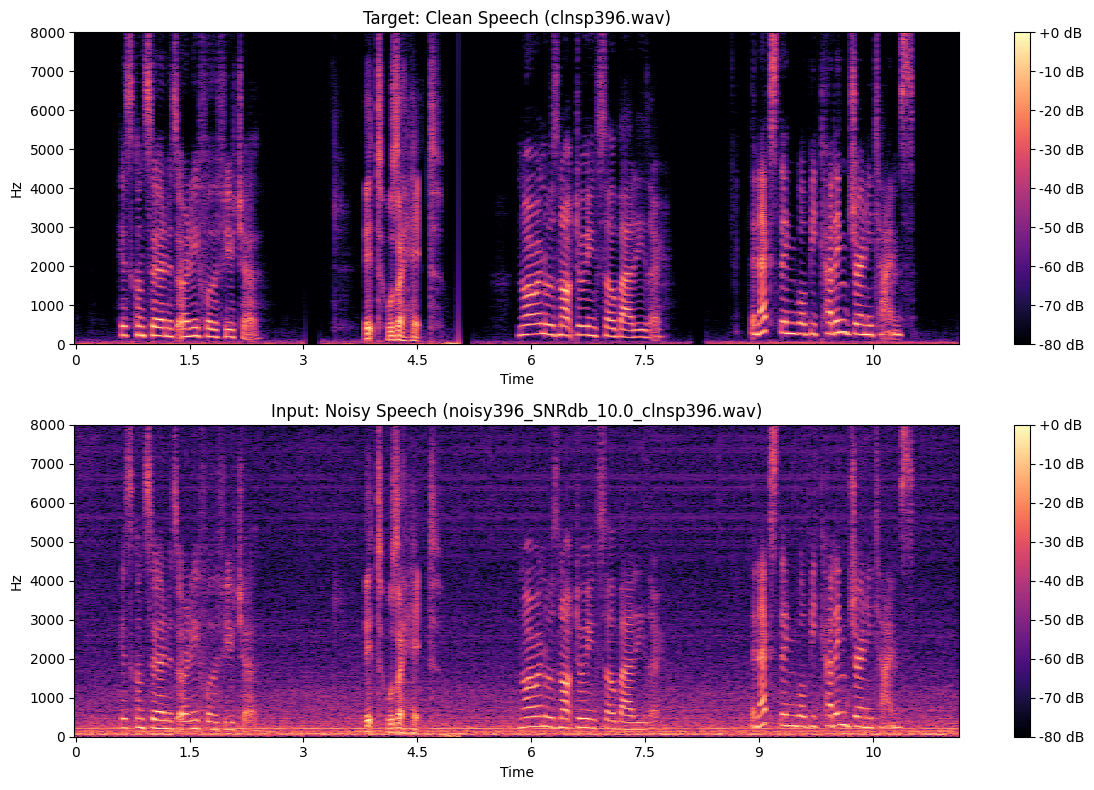

In [20]:
files = os.listdir(noisy_folder)
wav_files = [f for f in files if f.endswith('.wav')]

if not wav_files:
    print("Error: No .wav files found in NoisySpeech_training!")
else:
    filename = wav_files[0]
    print(f"Inspecting file: {filename}")

    noisy_path = os.path.join(noisy_folder, filename)

    file_id = filename.split('_')[-1]
    clean_path = os.path.join(clean_folder, file_id)

    if not os.path.exists(clean_path):
        print(f"Note: Exact match {file_id} not found. Using first available clean file.")
        clean_path = os.path.join(clean_folder, [f for f in os.listdir(clean_folder) if f.endswith('.wav')][0])

    noisy_audio, sr = librosa.load(noisy_path, sr=16000)
    clean_audio, _ = librosa.load(clean_path, sr=16000)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(clean_audio)), ref=np.max)
    librosa.display.specshow(D_clean, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Target: Clean Speech ({os.path.basename(clean_path)})')

    plt.subplot(2, 1, 2)
    D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_audio)), ref=np.max)
    librosa.display.specshow(D_noisy, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Input: Noisy Speech ({filename})')

    plt.tight_layout()
    plt.show()

<h2><b> Data Pre-Processing

In [21]:
SAMPLE_RATE = 16000
DURATION = 1.0
N_FFT = 255
HOP_LEN = 125

In [22]:
NOISY_DIR = os.path.join(base_dir, 'NoisySpeech_training')
CLEAN_DIR = os.path.join(base_dir, 'CleanSpeech_training')

In [23]:
def process_audio_data():
    x_data = []
    y_data = []

    print("Processing audio files...")

    noisy_files = [f for f in os.listdir(NOISY_DIR) if f.endswith('.wav')]

    for f in noisy_files:
        noisy_path = os.path.join(NOISY_DIR, f)
        audio_n, _ = librosa.load(noisy_path, sr=SAMPLE_RATE)

        clean_filename = f.split('_')[-1]
        clean_path = os.path.join(CLEAN_DIR, clean_filename)

        if not os.path.exists(clean_path):
            continue

        audio_c, _ = librosa.load(clean_path, sr=SAMPLE_RATE)

        samples_per_segment = int(SAMPLE_RATE * DURATION)
        num_segments = len(audio_n) // samples_per_segment

        for i in range(num_segments):
            start = i * samples_per_segment
            end = start + samples_per_segment

            seg_n = audio_n[start:end]
            seg_c = audio_c[start:end]

            spec_n = librosa.stft(seg_n, n_fft=N_FFT, hop_length=HOP_LEN)
            spec_c = librosa.stft(seg_c, n_fft=N_FFT, hop_length=HOP_LEN)

            mag_n = np.log1p(np.abs(spec_n))
            mag_c = np.log1p(np.abs(spec_c))

            x_data.append(mag_n.T)
            y_data.append(mag_c.T)

    X = np.array(x_data)
    Y = np.array(y_data)

    X = X[..., np.newaxis]
    Y = Y[..., np.newaxis]

    return X, Y

In [24]:
X_train, Y_train = process_audio_data()

print("Data Processing Complete!")
print(f"Input Shape: {X_train.shape}")
print(f"Target Shape: {Y_train.shape}")

Processing audio files...
Data Processing Complete!
Input Shape: (17283, 128, 128, 1)
Target Shape: (17283, 128, 128, 1)


In [25]:
def build_unet_model(input_shape):
    inputs = Input(shape=input_shape)

    c1 = Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)


    u2 = UpSampling2D((2, 2))(c3)
    u2 = Concatenate()([u2, c2])
    c4 = Conv2D(64, (3, 3), padding='same')(u2)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c1])
    c5 = Conv2D(32, (3, 3), padding='same')(u1)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    outputs = Conv2D(1, (1, 1), padding='same', activation='linear')(c5)

    model = Model(inputs, outputs)
    return model

input_shape = X_train.shape[1:]
model = build_unet_model(input_shape)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ activation_7[0][… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 192)              │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 232,321 (907.50 KB)

 Trainable params: 231,681 (905.00 KB)

 Non-trainable params: 640 (2.50 KB)

In [26]:
# --- 1. Define the Safety Brakes ---

# Safety Brake A: Stop if the model stops learning (prevents overfitting)
early_stopper = EarlyStopping(
    monitor='val_loss',     # Watch the Validation score (Orange line)
    patience=5,             # "If it doesn't get better for 5 epochs..."
    restore_best_weights=True, # "...Go back to the best version"
    verbose=1
)

# Safety Brake B: Save the best model automatically
checkpointer = ModelCheckpoint(
    filepath='best_mrdnn.keras', # Save to this file
    monitor='val_loss',
    save_best_only=True,    # Only save if it's the best score so far
    verbose=1
)

# --- 2. Train with the Brakes On ---
history = model.fit(
    X_train, Y_train,
    batch_size=32,          # Increased batch size for larger dataset
    epochs=50,              # You can even set this to 100 now, it will stop automatically!
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopper, checkpointer] # <--- Plug them in here!
)

# Save the final version just in case
model.save('mrdnn_final.keras')
print("Training Complete. Best model saved as 'best_mrdnn.keras'")

Epoch 1/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0651
Epoch 1: val_loss improved from inf to 0.01274, saving model to best_mrdnn.keras
487/487 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - loss: 0.0650 - val_loss: 0.0127
Epoch 2/50
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0088
Epoch 2: val_loss did not improve from 0.01274
487/487 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - loss: 0.0088 - val_loss: 0.0133
Epoch 3/50
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0080
Epoch 3: val_loss improved from 0.01274 to 0.00866, saving model to best_mrdnn.keras
487/487 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 4/50
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0073
Epoch 4: val_loss improved from 0.00866 to 0.00688, saving model to best_mrdnn.keras
487/487 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 5/50
486/487 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0069
Epoch 5: val_loss did not improve from 0.00688
487/487

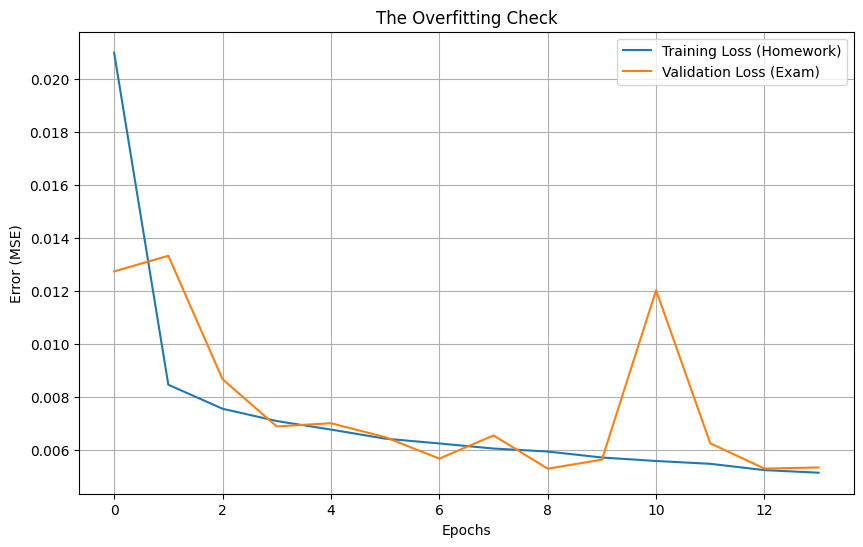

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (Homework)')
plt.plot(history.history['val_loss'], label='Validation Loss (Exam)')
plt.title('The Overfitting Check')
plt.xlabel('Epochs')
plt.ylabel('Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()